Dataset shape: (9015, 15)
Columns: ['STATE/UT', 'DISTRICT', 'Year', 'Murder', 'Rape', 'Kidnapping and Abduction', 'Foeticide', 'Abetment of suicide', 'Exposure and abandonment', 'Procuration of minor girls', 'Buying of girls for prostitution', 'Selling of girls for prostitution', 'Prohibition of child marriage act', 'Other Crimes', 'Total']
Cleaned shape: (9014, 15)
Neglect value counts:
 Neglect
0    7053
1    1961
Name: count, dtype: int64


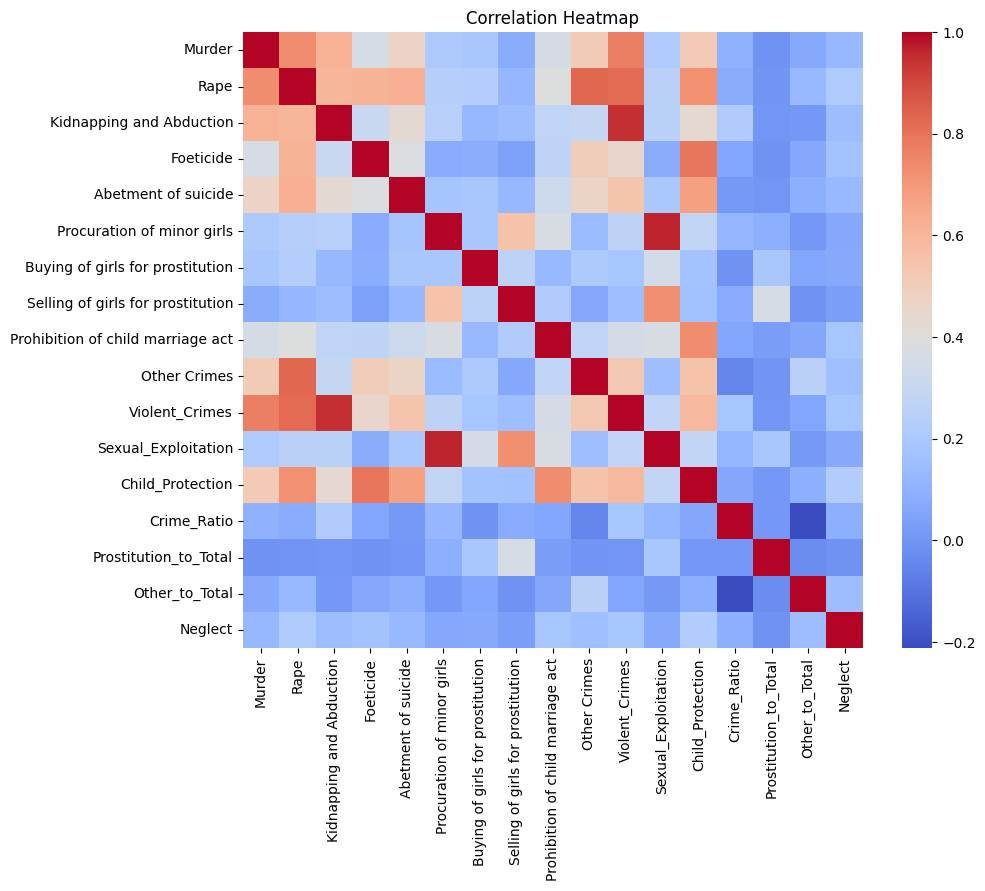

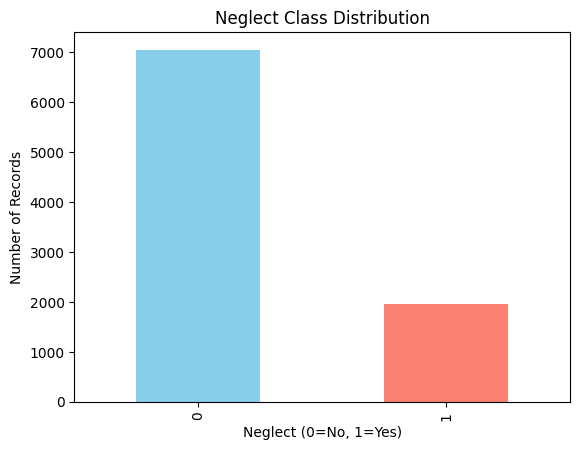

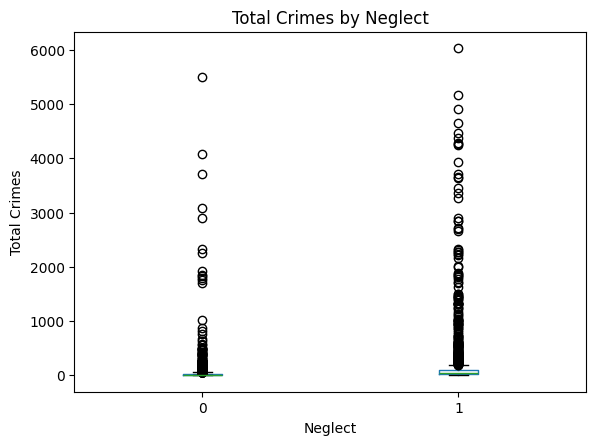

After SMOTE balancing:
 Neglect
0    5642
1    5642
Name: count, dtype: int64

Accuracy: 0.831946755407654

ROC-AUC: 0.8425969785504563

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.89      1411
           1       0.62      0.58      0.60       392

    accuracy                           0.83      1803
   macro avg       0.75      0.74      0.75      1803
weighted avg       0.83      0.83      0.83      1803



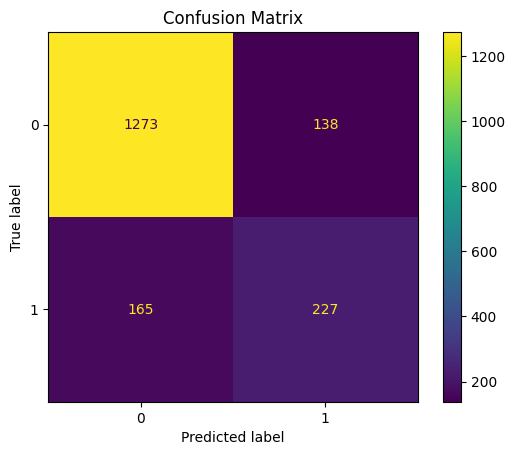


Cross-validated Accuracy: 0.847 ± 0.007


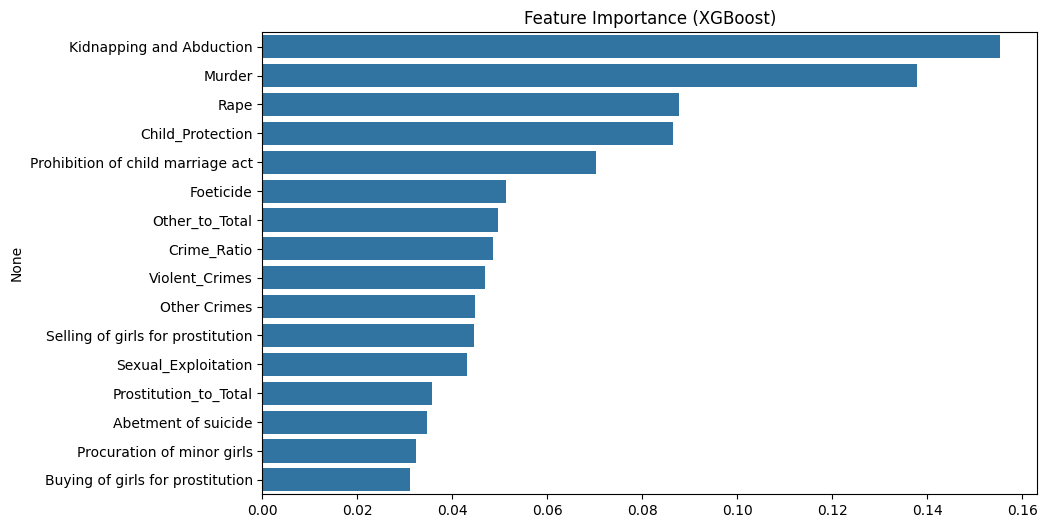


Sample predictions:
    Actual  Predicted  Pred_Prob
0       0          1      0.535
1       0          0      0.151
2       0          1      0.670
3       0          0      0.206
4       0          0      0.062
5       1          1      0.803
6       0          0      0.039
7       0          0      0.043
8       0          1      0.590
9       0          0      0.109


In [ ]:
# ----------------------------------------
# 1. Import Libraries
# ----------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score, ConfusionMatrixDisplay
)

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# ----------------------------------------
# 2. Load Dataset
# ----------------------------------------
df = pd.read_csv("dstrCAC.csv")
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

# ----------------------------------------
# 3. Keep Only Important Columns
# ----------------------------------------
important_cols = [
    'STATE/UT', 'DISTRICT', 'Year', 'Murder', 'Rape', 'Kidnapping and Abduction',
    'Foeticide', 'Abetment of suicide', 'Exposure and abandonment',
    'Procuration of minor girls', 'Buying of girls for prostitution',
    'Selling of girls for prostitution', 'Prohibition of child marriage act',
    'Other Crimes', 'Total'
]
keep = [c for c in important_cols if c in df.columns]
df = df[keep].copy()

# ----------------------------------------
# 4. Data Cleaning
# ----------------------------------------
num_cols = [c for c in df.columns if c not in ['STATE/UT','DISTRICT','Year']]
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

df.drop_duplicates(inplace=True)
print("Cleaned shape:", df.shape)

# ----------------------------------------
# 5. Create Target Column 'Neglect'
# ----------------------------------------
df['Neglect'] = (df['Exposure and abandonment'] > 0).astype(int)
print("Neglect value counts:\n", df['Neglect'].value_counts())

# ----------------------------------------
# 6. Feature Engineering
# ----------------------------------------
df['Violent_Crimes'] = df['Murder'] + df['Rape'] + df['Kidnapping and Abduction']
df['Sexual_Exploitation'] = (
    df['Buying of girls for prostitution'] +
    df['Selling of girls for prostitution'] +
    df['Procuration of minor girls']
)
df['Child_Protection'] = (
    df['Foeticide'] + df['Prohibition of child marriage act'] + df['Abetment of suicide']
)
df['Crime_Ratio'] = (df['Violent_Crimes'] + 1) / (df['Other Crimes'] + 1)
df['Prostitution_to_Total'] = (
    (df['Buying of girls for prostitution'] + df['Selling of girls for prostitution']) /
    (df['Total'] + 1)
)
df['Other_to_Total'] = df['Other Crimes'] / (df['Total'] + 1)

# ----------------------------------------
# 7. Feature Selection (no leakage)
# ----------------------------------------
feature_cols = [
    'Murder', 'Rape', 'Kidnapping and Abduction', 'Foeticide',
    'Abetment of suicide', 'Procuration of minor girls',
    'Buying of girls for prostitution', 'Selling of girls for prostitution',
    'Prohibition of child marriage act', 'Other Crimes',
    'Violent_Crimes', 'Sexual_Exploitation', 'Child_Protection',
    'Crime_Ratio', 'Prostitution_to_Total', 'Other_to_Total'
]

X = df[feature_cols]
y = df['Neglect']

# ----------------------------------------
# 8. Data Visualization
# ----------------------------------------
plt.figure(figsize=(10,8))
sns.heatmap(df[feature_cols + ['Neglect']].corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()

df['Neglect'].value_counts().plot(kind='bar', color=['skyblue','salmon'])
plt.title("Neglect Class Distribution")
plt.xlabel("Neglect (0=No, 1=Yes)")
plt.ylabel("Number of Records")
plt.show()

# Boxplot for Total Crimes vs Neglect
df.boxplot(column='Total', by='Neglect', grid=False)
plt.title("Total Crimes by Neglect")
plt.suptitle('')
plt.xlabel("Neglect")
plt.ylabel("Total Crimes")
plt.show()

# ----------------------------------------
# 9. Train-Test Split
# ----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ----------------------------------------
# 10. Scaling + Balancing
# ----------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)
print("After SMOTE balancing:\n", pd.Series(y_train_bal).value_counts())

# ----------------------------------------
# 11. Model Training (XGBoost)
# ----------------------------------------
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=len(y_train_bal[y_train_bal==0]) / len(y_train_bal[y_train_bal==1]),
    eval_metric='logloss'
)

model.fit(X_train_bal, y_train_bal)

# ----------------------------------------
# 12. Model Evaluation
# ----------------------------------------
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:,1]

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.show()

# ----------------------------------------
# 13. Cross-Validation
# ----------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
print("\nCross-validated Accuracy: {:.3f} ± {:.3f}".format(cv_scores.mean(), cv_scores.std()))

# ----------------------------------------
# 14. Feature Importance
# ----------------------------------------
importances = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Feature Importance (XGBoost)")
plt.show()

# ----------------------------------------
# 15. Sample Predictions
# ----------------------------------------
pred_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": y_pred,
    "Pred_Prob": np.round(y_prob, 3)
})
print("\nSample predictions:\n", pred_df.head(10))

In [ ]:
# ----------------------------------------
# 16. Save Model as Pickle File
# ----------------------------------------
import pickle

# Save model
with open('child_neglect_xgb_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model saved as child_neglect_xgb_model.pkl")

# Download the pickle file in Colab
from google.colab import files
files.download('child_neglect_xgb_model.pkl')


Model saved as child_neglect_xgb_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save the fitted scaler as well!
with open('child_neglect_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

from google.colab import files
files.download('child_neglect_scaler.pkl')
#

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import json
with open('feature_cols.json', 'w') as f:
    json.dump(feature_cols, f)
files.download('feature_cols.json')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
with open('requirements.txt', 'w') as f:
    f.write('numpy\npandas\nscikit-learn\nxgboost\nimblearn\n')
from google.colab import files
files.download('requirements.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>